In [1]:
%matplotlib widget
import torch
import numpy as np
import torch.optim as optim
from simple_pinn import SimplePINN
import matplotlib.pyplot as plt
import scipy.io

In [2]:
model = SimplePINN(
    2, [100, 100, 100, 100, 100, 100], 2
)  # the inputs are the ordered tuple (x, t); the output is u(x, t), v(x, t)
print(model)

SimplePINN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1-5): 5 x Linear(in_features=100, out_features=100, bias=True)
  )
  (head): Linear(in_features=100, out_features=2, bias=True)
)


In [3]:
X_DOMAIN = (-5.0, 5.0)  # x boundaries of the problem
T_DOMAIN = (0.0, torch.pi / 2)  # t boundaries of the problem

In [4]:
def compute_loss(model, batch_size):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    init_batch_size = batch_size // 10
    bc_batch_size = batch_size // 10

    # sample the collocation points
    x = (
        torch.rand(batch_size, 1, requires_grad=True) * (X_DOMAIN[1] - X_DOMAIN[0])
        + X_DOMAIN[0]
    ).to(device)
    t = (
        torch.rand(batch_size, 1, requires_grad=True) * (T_DOMAIN[1] - T_DOMAIN[0])
        + T_DOMAIN[0]
    ).to(device)
    # forward pass through the model at the collocation points
    input = torch.cat((x, t), dim=1)
    h = model(input)
    # get the real and imaginary componenets of the solution separately
    # (in principle, PyTorch has a complex datatype, but I wasn't able to get derivatives of it working properly)
    u, v = h[:, 0].unsqueeze(1), h[:, 1].unsqueeze(1)
    # calculate the partials of u and v needed for the residual loss function
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[
        0
    ]
    u_xx = torch.autograd.grad(
        u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[
        0
    ]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[
        0
    ]
    v_xx = torch.autograd.grad(
        v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True
    )[0]
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[
        0
    ]
    # evaluate the component-wise residual loss at the collocation points
    # this is just the real and imaginary componenets of i h_t + 0.5 * h_xx + |h|^2 h if h = u + i v
    residual_u = v_t - 0.5 * u_xx - (torch.square(u) + torch.square(v)) * u
    residual_v = u_t + 0.5 * v_xx + (torch.square(u) + torch.square(v)) * v
    # and sum them up
    residual_loss = torch.mean(torch.square(residual_u) + torch.square(residual_v))

    # sample the initial condition points
    x_0 = (
        torch.rand(init_batch_size, 1) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]
    ).to(device)
    t_0 = torch.zeros_like(x_0).to(device)
    # forward pass through the model at the initial condition points
    input_0 = torch.cat((x_0, t_0), dim=1)
    h_0_pred = model(input_0)
    u_0_pred, v_0_pred = h_0_pred[:, 0].unsqueeze(1), h_0_pred[:, 1].unsqueeze(1)
    # evaluate the initial condition loss
    u_0_exact = 2.0 / torch.cosh(x_0)  # <-- initial condition as specified in the paper
    # implicitly, v_0_exact = 0
    init_loss = torch.mean(torch.square(u_0_pred - u_0_exact) + torch.square(v_0_pred))

    # sample the boundary condition points
    x_lb = (torch.ones(bc_batch_size, 1, requires_grad=True) * X_DOMAIN[0]).to(device)
    x_rb = (torch.ones(bc_batch_size, 1, requires_grad=True) * X_DOMAIN[1]).to(device)
    t = (torch.rand(bc_batch_size, 1) * (T_DOMAIN[1] - T_DOMAIN[0]) + T_DOMAIN[0]).to(
        device
    )
    # forward pass through the model at the boundary condition points
    input_lb = torch.cat((x_lb, t), dim=1)
    input_rb = torch.cat((x_rb, t), dim=1)
    h_lb = model(input_lb)
    h_rb = model(input_rb)
    u_lb, v_lb = h_lb[:, 0].unsqueeze(1), h_lb[:, 1].unsqueeze(1)
    u_rb, v_rb = h_rb[:, 0].unsqueeze(1), h_rb[:, 1].unsqueeze(1)
    # evaluate (the first part of) the boundary condition loss
    bc_loss_val = torch.square(u_lb - u_rb) + torch.square(v_lb - v_rb)
    # take partials to compute the second component of the boundary condition loss
    u_x_lb = torch.autograd.grad(
        u_lb, x_lb, grad_outputs=torch.ones_like(u_lb), create_graph=True
    )[0]
    v_x_lb = torch.autograd.grad(
        v_lb, x_lb, grad_outputs=torch.ones_like(v_lb), create_graph=True
    )[0]
    u_x_rb = torch.autograd.grad(
        u_rb, x_rb, grad_outputs=torch.ones_like(u_rb), create_graph=True
    )[0]
    v_x_rb = torch.autograd.grad(
        v_rb, x_rb, grad_outputs=torch.ones_like(v_rb), create_graph=True
    )[0]
    bc_loss_partials = torch.square(u_x_lb - u_x_rb) + torch.square(v_x_lb - v_x_rb)
    # and sum them up
    bc_loss = torch.mean(bc_loss_val + bc_loss_partials)

    # compute the total loss
    loss = residual_loss + init_loss + bc_loss
    return loss

In [5]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 20_000
n_epochs = 20_000

In [6]:
loss_history = []
for epoch in range(n_epochs):
    loss = compute_loss(model, batch_size)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1} | Loss: {loss.item():.6f}")
    loss_history.append(loss.item())

Epoch 1 | Loss: 0.743609
Epoch 2 | Loss: 0.643253
Epoch 3 | Loss: 0.526427
Epoch 4 | Loss: 0.461512
Epoch 5 | Loss: 0.386256
Epoch 6 | Loss: 0.368876
Epoch 7 | Loss: 0.401650
Epoch 8 | Loss: 0.378087
Epoch 9 | Loss: 0.336008
Epoch 10 | Loss: 0.327735
Epoch 11 | Loss: 0.309876
Epoch 12 | Loss: 0.315053
Epoch 13 | Loss: 0.313451
Epoch 14 | Loss: 0.299084
Epoch 15 | Loss: 0.271267
Epoch 16 | Loss: 0.231911
Epoch 17 | Loss: 0.232195
Epoch 18 | Loss: 0.225802
Epoch 19 | Loss: 0.229587
Epoch 20 | Loss: 0.199785
Epoch 21 | Loss: 0.180662
Epoch 22 | Loss: 0.187951
Epoch 23 | Loss: 0.196148
Epoch 24 | Loss: 0.184457
Epoch 25 | Loss: 0.159983
Epoch 26 | Loss: 0.156980
Epoch 27 | Loss: 0.157807
Epoch 28 | Loss: 0.148823
Epoch 29 | Loss: 0.145576
Epoch 30 | Loss: 0.145273
Epoch 31 | Loss: 0.146626
Epoch 32 | Loss: 0.135633
Epoch 33 | Loss: 0.141616
Epoch 34 | Loss: 0.144301
Epoch 35 | Loss: 0.136947
Epoch 36 | Loss: 0.137587
Epoch 37 | Loss: 0.131153
Epoch 38 | Loss: 0.132550
Epoch 39 | Loss: 0.12

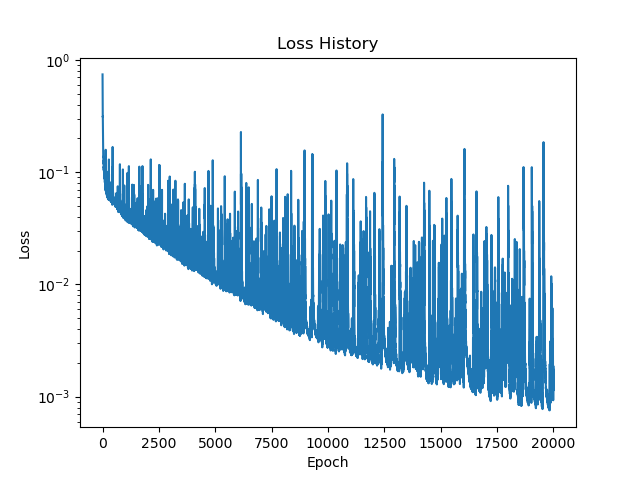

In [7]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss History")
plt.semilogy()
plt.show()

In [8]:
# load the exact solution for comparison
data = scipy.io.loadmat("../PINNs/main/Data/NLS.mat")
x = torch.tensor(data["x"].flatten(), dtype=torch.float32)  # 256
t = torch.tensor(data["tt"].flatten(), dtype=torch.float32)  # 201
u_exact = torch.tensor(np.real(data["uu"]), dtype=torch.float32)  # 256 x 201
v_exact = torch.tensor(np.imag(data["uu"]), dtype=torch.float32)  # 256 x 201
h_exact_mag = torch.sqrt(torch.square(u_exact) + torch.square(v_exact))

In [9]:
# evaluate the model prediction on the same grid as the exact solution
X, T = torch.meshgrid(x, t, indexing="ij")
x_sample = torch.reshape(X, (-1, 1))
y_sample = torch.reshape(T, (-1, 1))
input = torch.cat((x_sample, y_sample), dim=1)
model.to("cpu")
h_pred = model(input)
u_pred, v_pred = h_pred[:, 0].unsqueeze(1), h_pred[:, 1].unsqueeze(1)
u_pred = u_pred.reshape(u_exact.shape)
v_pred = v_pred.reshape(v_exact.shape)
h_pred_mag = torch.sqrt(torch.square(u_pred) + torch.square(v_pred))

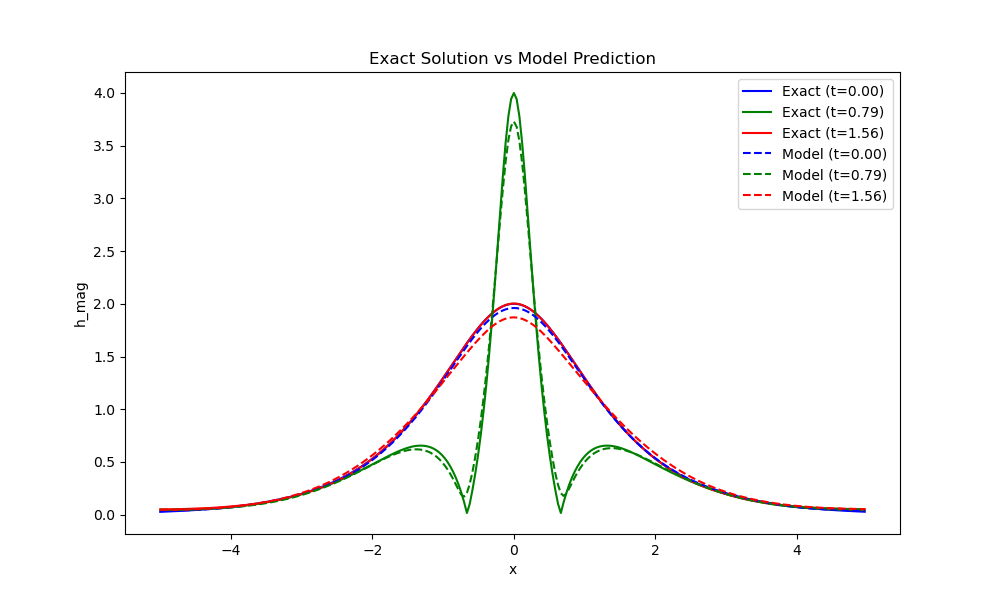

In [10]:
sample_times = [0, 100, 199]
colors = ["b", "g", "r", "c", "m"]

# Plot the exact solution
plt.figure(figsize=(10, 6))
for i, t_idx in enumerate(sample_times):
    plt.plot(
        x, h_exact_mag[:, t_idx], color=colors[i], label=f"Exact (t={t[t_idx]:.2f})"
    )

# Plot the model prediction
for i, t_idx in enumerate(sample_times):
    plt.plot(
        x,
        h_pred_mag[:, t_idx].detach().numpy(),
        "--",
        color=colors[i],
        label=f"Model (t={t[t_idx]:.2f})",
    )

plt.xlabel("x")
plt.ylabel("h_mag")
plt.title("Exact Solution vs Model Prediction")
plt.legend()
plt.show()